# 1. Import libraries


In [36]:
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from datetime import date

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots 
import plotly.express as px
import plotly.graph_objects as go 

from sklearn.model_selection import TimeSeriesSplit 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


# 2. Importing Data


In [37]:
train_df = pd.read_csv('./playground-series-s3e19/train.csv')
test_df = pd.read_csv('./playground-series-s3e19/test.csv')

print("Shape of training set: ", train_df.shape)
print("Shape of test set: ", test_df.shape)


Shape of training set:  (136950, 6)
Shape of test set:  (27375, 5)


# 3. EDA & Data preprocessing

In [38]:
def preprocess_df(df):
    df.drop('id', axis=1, inplace=True)
    
    # Split date into year, motnth and day
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    
    # Add weekends column
    df['day_of_week'] = df['date'].dt.dayofweek
    df.loc[df['day_of_week'] > 4, 'weekend'] = 1
    df.loc[df['day_of_week'] <= 4, 'weekend'] = 0
    
    return df
    

In [39]:
train_df = preprocess_df(train_df)
test_df = preprocess_df(test_df)

## 3.1 Univariate analysis

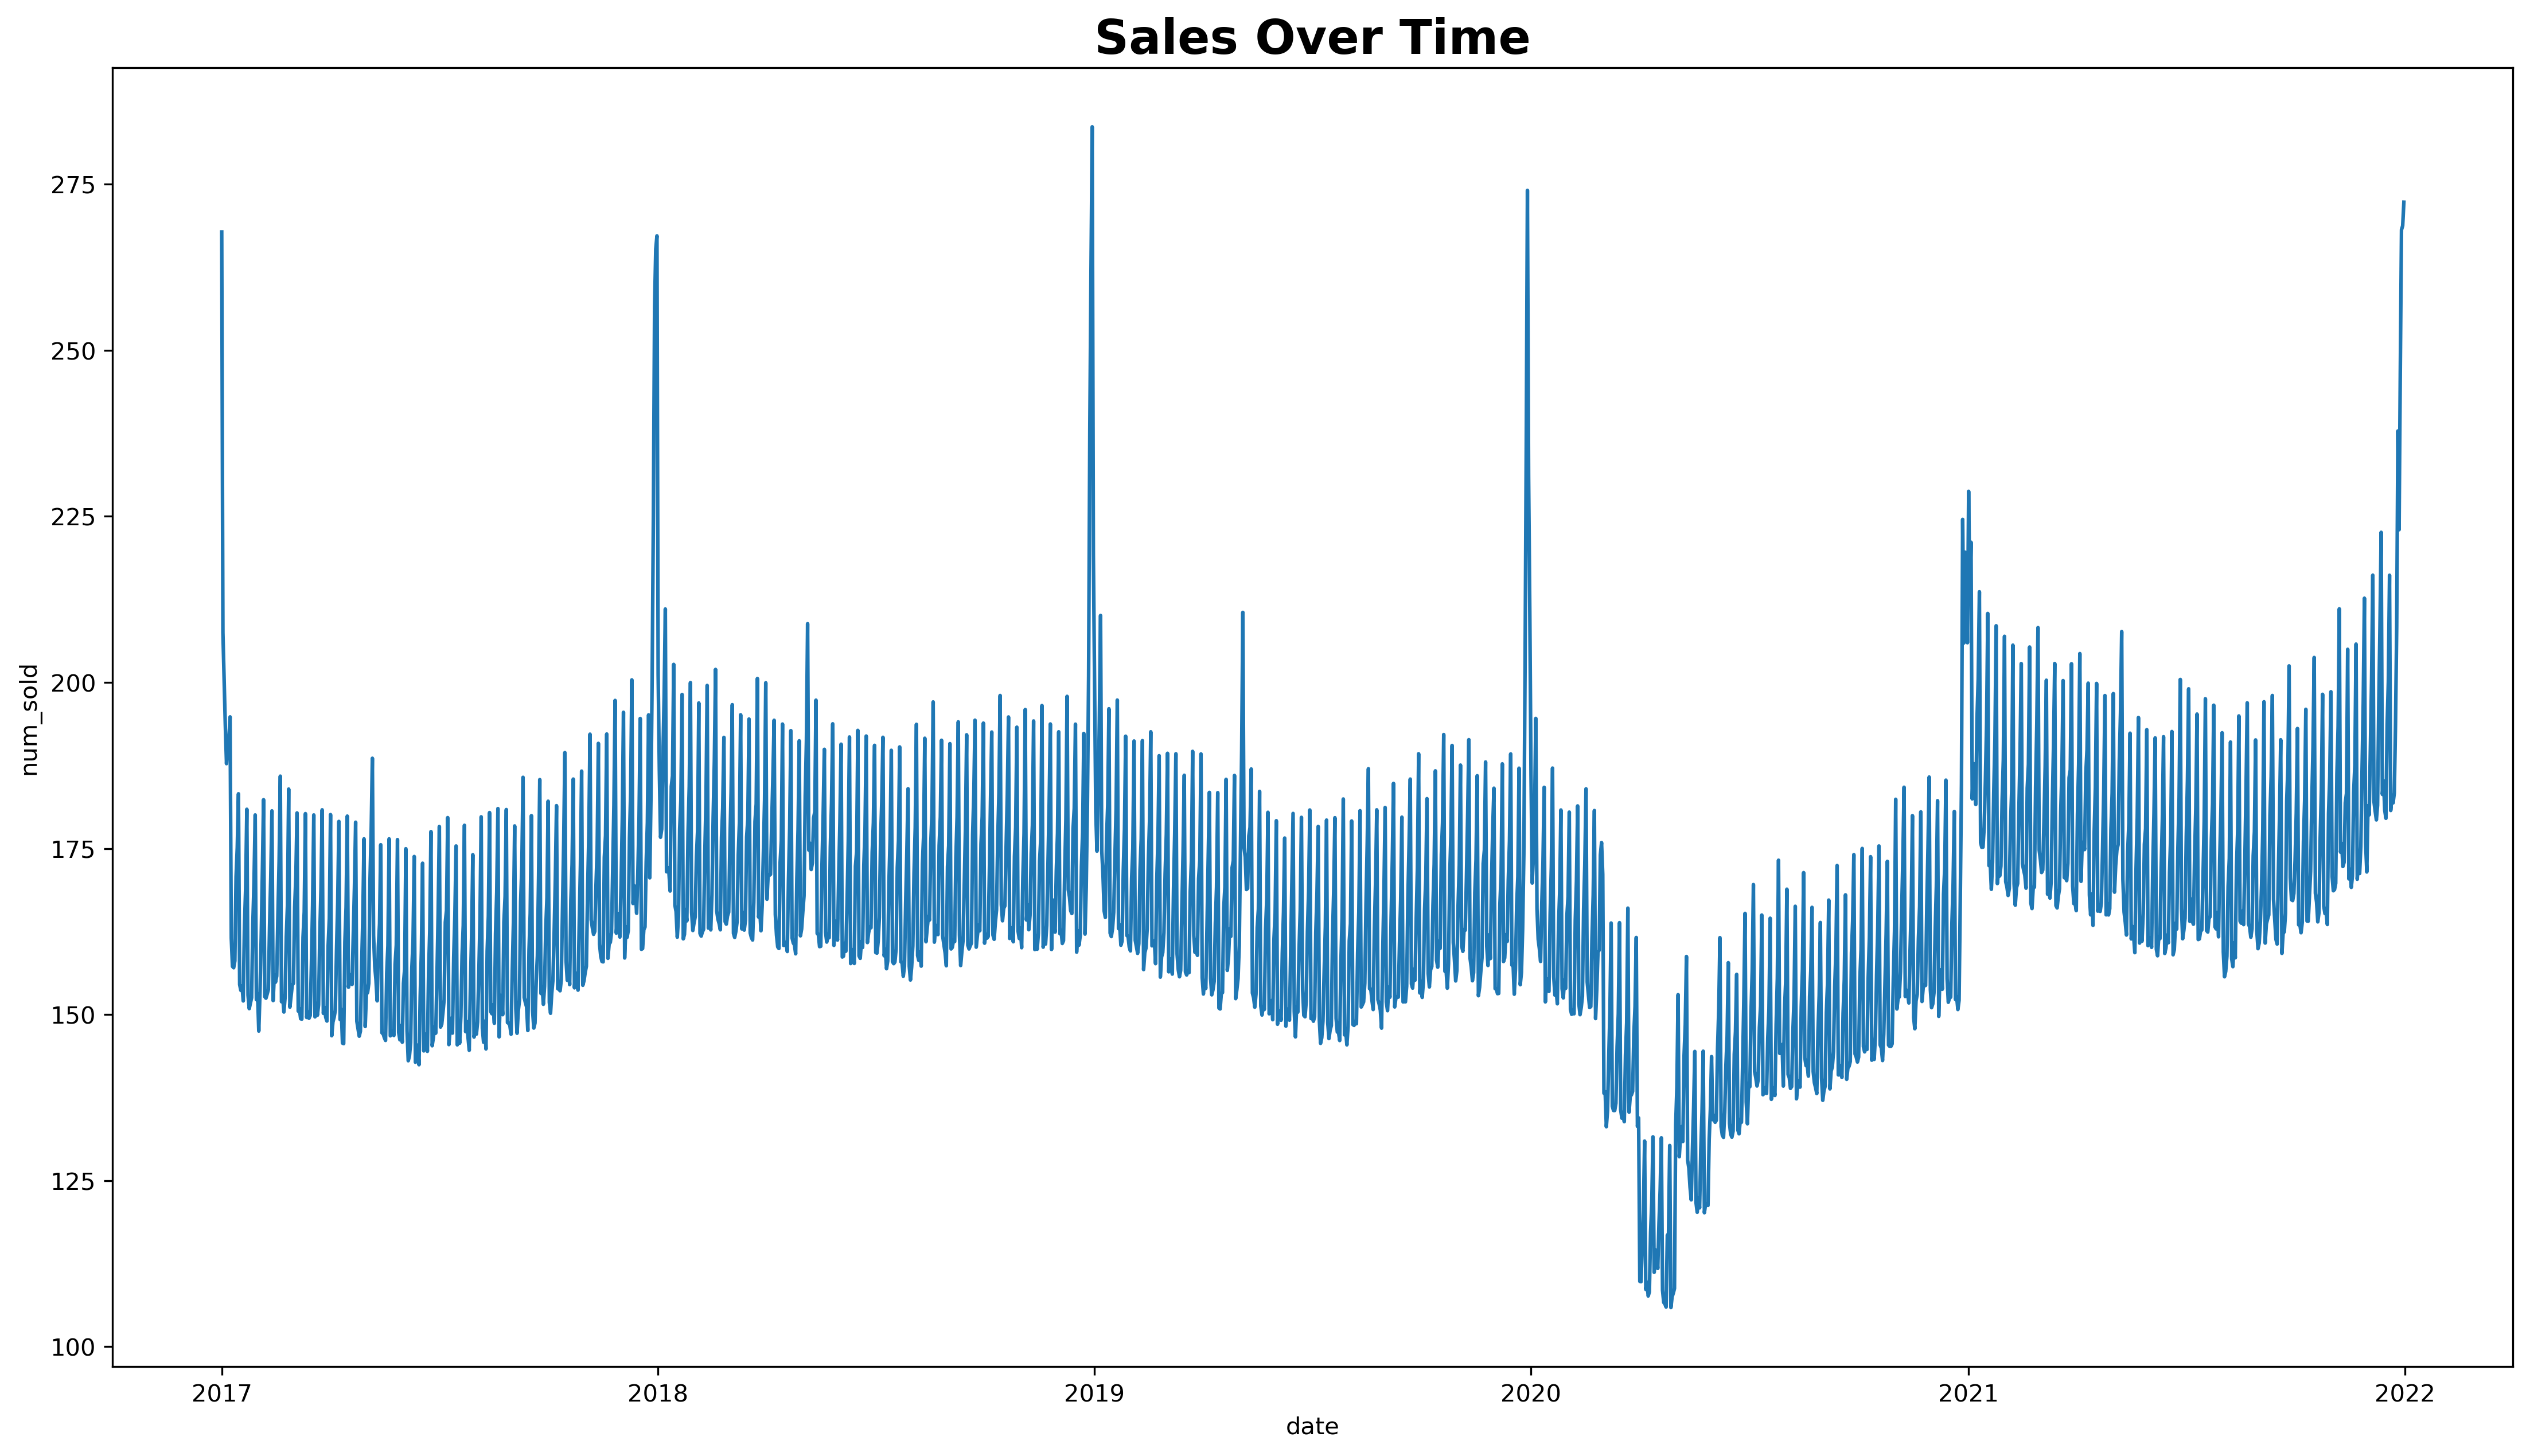

In [41]:
# All sales over time visualization
plt.figure(figsize = (18, 10), dpi = 300)

sns.lineplot(data = train_df, x = 'date', y = 'num_sold', errorbar = None)
    
plt.title('Sales Over Time', fontsize = 20, fontweight = 'bold')
plt.show()

### Data distribution

In [42]:
#Train data
print("[TRAIN DATA]")
print(train_df['store'].value_counts(), '\n')
print(train_df['country'].value_counts(), '\n')
print(train_df['product'].value_counts())

#tEST data
print("[TEST DATA]")
print(test_df['store'].value_counts(), '\n')
print(test_df['country'].value_counts(), '\n')
print(test_df['product'].value_counts())

[TRAIN DATA]
Kaggle Learn    45650
Kaggle Store    45650
Kagglazon       45650
Name: store, dtype: int64 

Argentina    27390
Canada       27390
Estonia      27390
Japan        27390
Spain        27390
Name: country, dtype: int64 

Using LLMs to Improve Your Coding                 27390
Using LLMs to Train More LLMs                     27390
Using LLMs to Win Friends and Influence People    27390
Using LLMs to Win More Kaggle Competitions        27390
Using LLMs to Write Better                        27390
Name: product, dtype: int64
[TEST DATA]
Kaggle Learn    9125
Kaggle Store    9125
Kagglazon       9125
Name: store, dtype: int64 

Argentina    5475
Canada       5475
Estonia      5475
Japan        5475
Spain        5475
Name: country, dtype: int64 

Using LLMs to Improve Your Coding                 5475
Using LLMs to Train More LLMs                     5475
Using LLMs to Win Friends and Influence People    5475
Using LLMs to Win More Kaggle Competitions        5475
Using LLMs to Wri

### Sales by different time frames and periods

In [43]:
train_df['year'] = train_df['date'].dt.year
train_df['day'] = train_df['date'].dt.day
train_df['month'] = train_df['date'].dt.month

In [46]:


sales_by_month = train_df.groupby(by='month')['num_sold'].mean()
sales_by_year = train_df.groupby(by='year')['num_sold'].mean()
# Sales by month visualization
fig = px.line(train_df, x=train_df['month'].unique(), y=sales_by_month, markers=True, width=1000, height=400)
fig.update_layout(
    xaxis=dict(
        tickmode='linear',
    )
)
fig.show()

fig2 = px.line(train_df, x=train_df['year'].unique(), y=sales_by_year, markers=True, width=1000, height=400)
fig2.update_layout(
    xaxis=dict(
        tickmode='linear',
    )
)
fig2.show()

### Data duration

In [47]:
def get_data_duration(data):
    data = data.copy()
    data['date'] = pd.to_datetime(data['date'])
    days = data['date'].max() - data['date'].min()
    return days
    
    
print('Train set duration', get_data_duration(train_df))
print('Test set duration', get_data_duration(test_df))

Train set duration 1825 days 00:00:00
Test set duration 364 days 00:00:00


## 3.2 Multivariate analysis

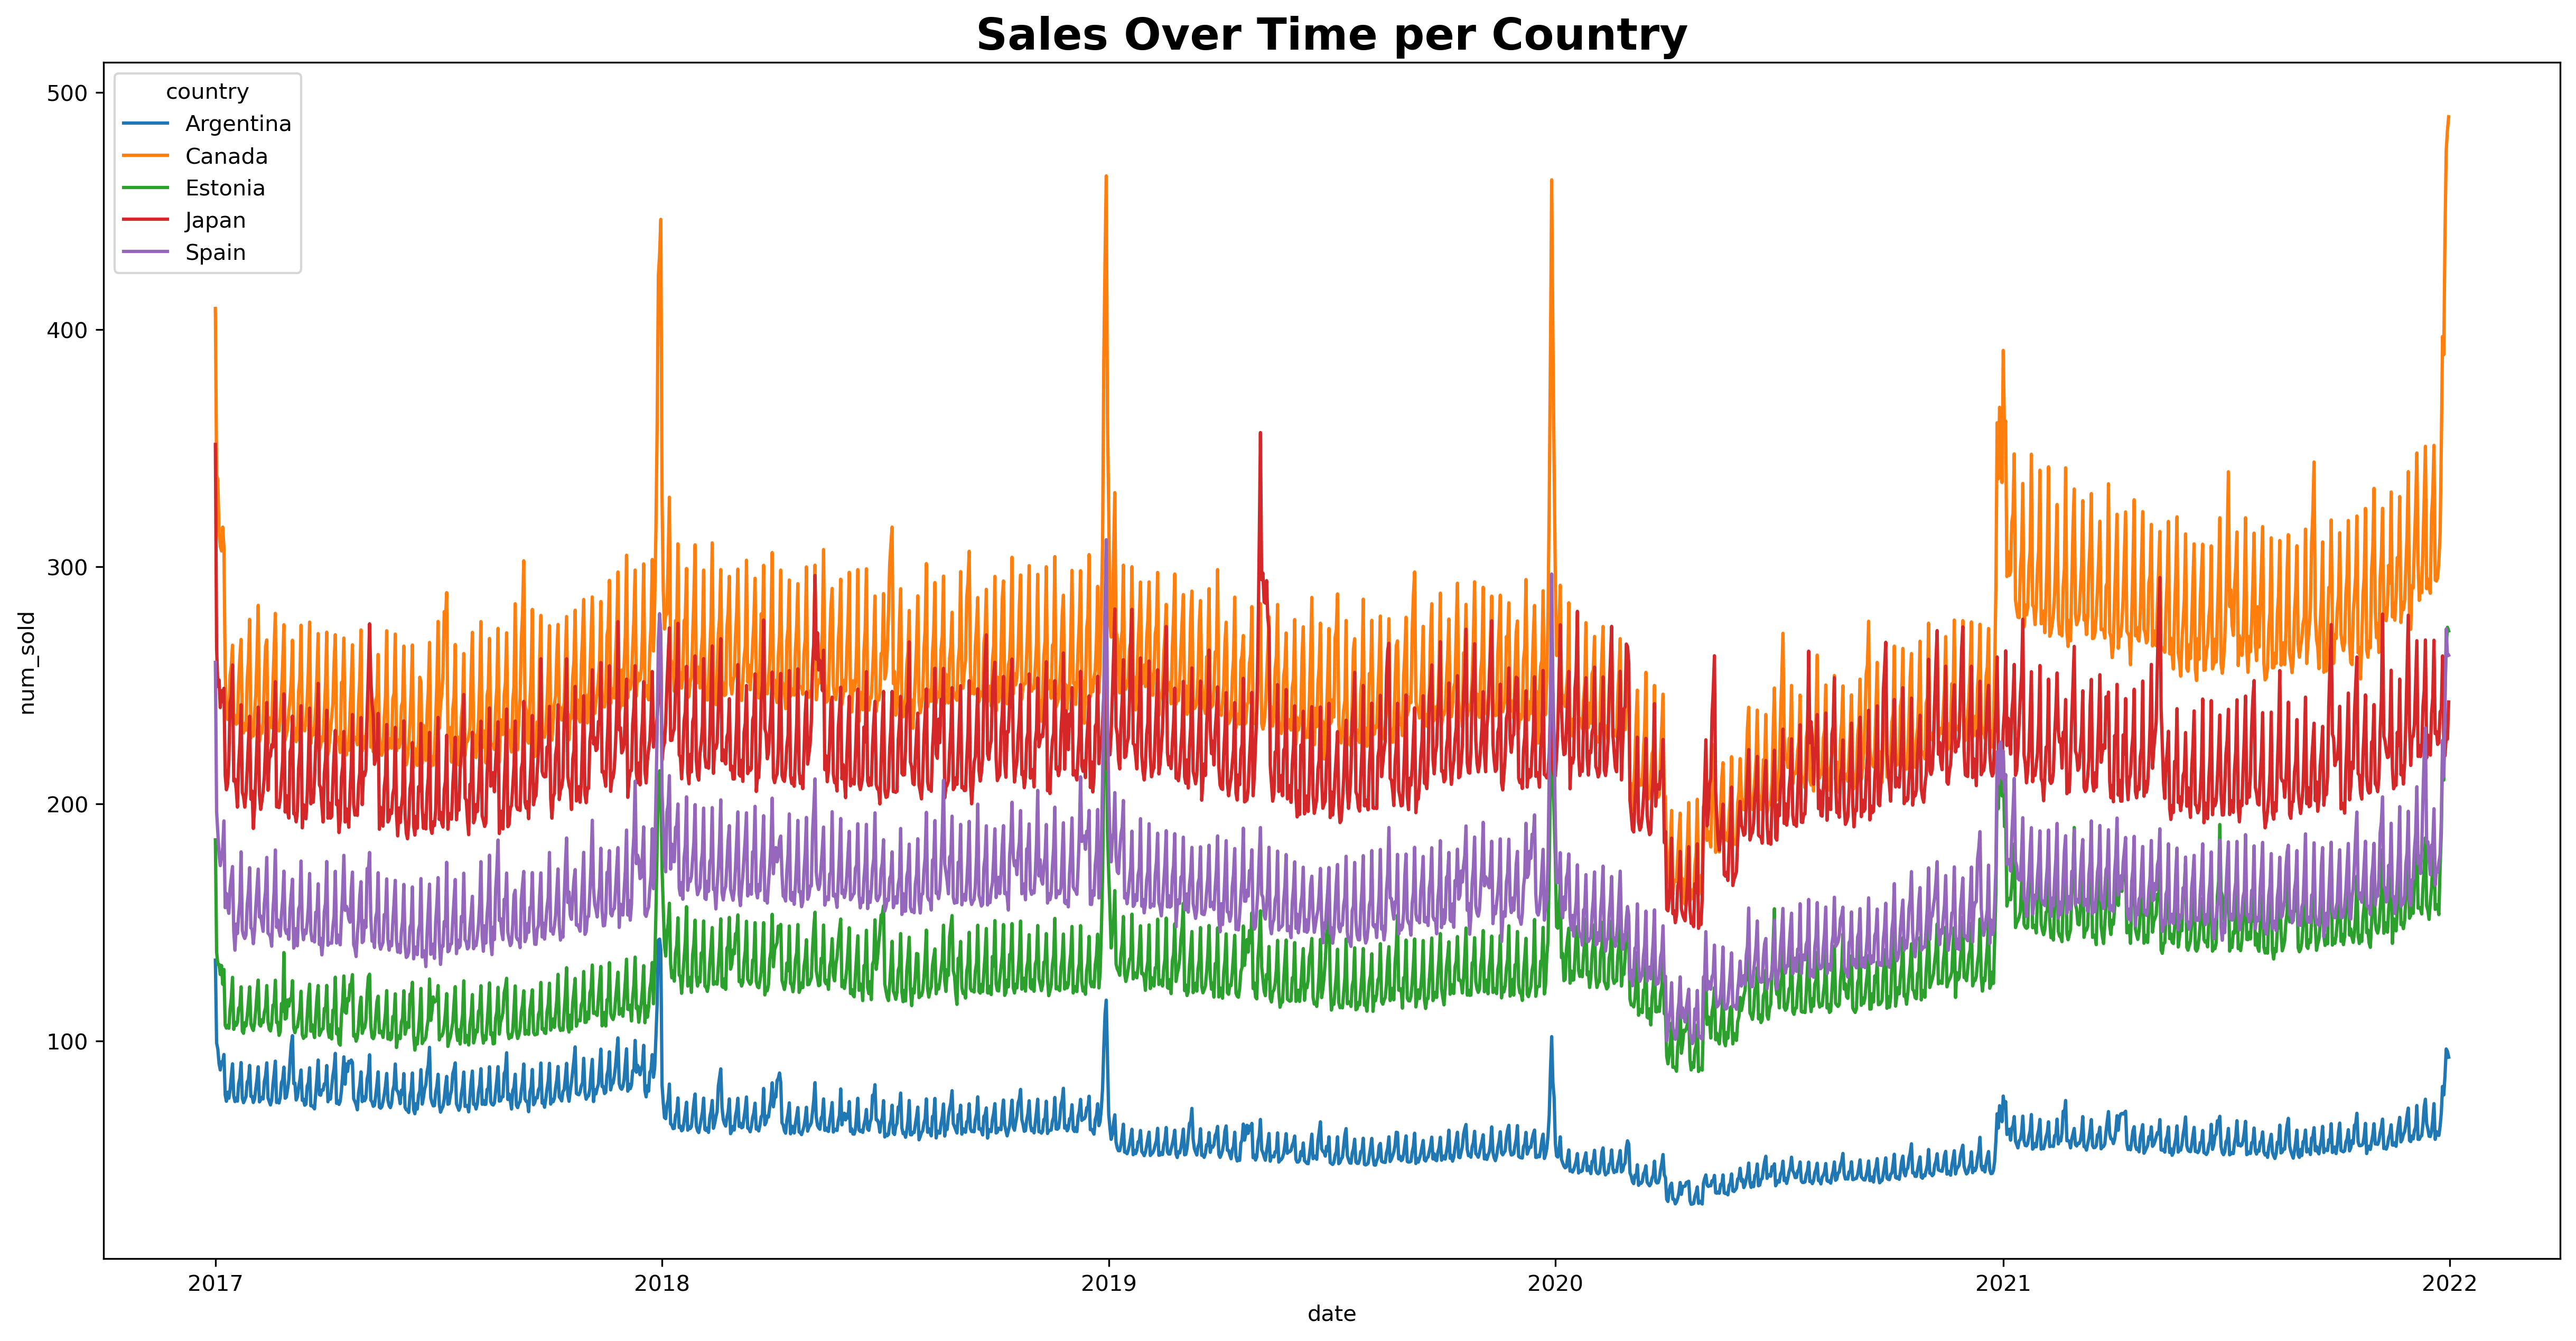

In [48]:
# Sales over time by country
plt.figure(figsize = (20, 10), dpi = 300)

sns.lineplot(data = train_df, x = 'date', y = 'num_sold', hue = 'country', errorbar = None)
    
plt.title('Sales Over Time per Country', fontsize = 20, fontweight = 'bold')
plt.show()

All countries show simmilar sales trends

In [49]:
monthly_sales_product = train_df.groupby([train_df['date'].dt.to_period('M'), 'product']).mean()['num_sold'].reset_index()
monthly_sales_product['date'] = monthly_sales_product['date'].dt.to_timestamp()

fig = px.line(monthly_sales_product,
              x='date', y='num_sold', color='product')

fig.update_layout(
    title_text='Monthly Sales by Prodcut',
    xaxis=dict(
        title='Product',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Average Number of Products Sold',
        titlefont_size=16
    ),
    template='plotly_dark'
)
fig.show()


In [50]:
# Sales by stores

monthly_sales_store = train_df.groupby([train_df['date'].dt.to_period('M'), 'store']).mean()['num_sold'].reset_index()
monthly_sales_store['date'] = monthly_sales_store['date'].dt.to_timestamp() 

fig = px.line(data_frame=monthly_sales_store, x='date', y='num_sold', color='store')
fig.update_layout(
    title_text='Monthly Sales by Store',
    xaxis=dict(
        title='Store',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Average Number of Products Sold',
        titlefont_size=16
    ),
    template='plotly_dark'
)
fig.show()



## 3.3 Additional Preprocessing


In [51]:
def one_hot_encode(data, columns):
    data = pd.get_dummies(data, columns=columns)
    return data


train_df = one_hot_encode(train_df, ['store', 'product', 'country'])
test_df = one_hot_encode(test_df, ['store', 'product', 'country'])

In [52]:
print(train_df.shape)
print(train_df.columns)
print(train_df.describe(include='all'))

(136950, 20)
Index(['date', 'num_sold', 'year', 'month', 'day', 'day_of_week', 'weekend',
       'store_Kagglazon', 'store_Kaggle Learn', 'store_Kaggle Store',
       'product_Using LLMs to Improve Your Coding',
       'product_Using LLMs to Train More LLMs',
       'product_Using LLMs to Win Friends and Influence People',
       'product_Using LLMs to Win More Kaggle Competitions',
       'product_Using LLMs to Write Better', 'country_Argentina',
       'country_Canada', 'country_Estonia', 'country_Japan', 'country_Spain'],
      dtype='object')
                       date       num_sold           year          month  \
count                136950  136950.000000  136950.000000  136950.000000   
unique                 1826            NaN            NaN            NaN   
top     2017-01-01 00:00:00            NaN            NaN            NaN   
freq                     75            NaN            NaN            NaN   
first   2017-01-01 00:00:00            NaN            NaN          

# 4 Modelling

## 4.1 Evaluation function

In [53]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [54]:
train_df.drop('date', axis=1, inplace=True)

In [55]:
X = train_df.drop('num_sold', axis=1)
y = train_df['num_sold']

In [56]:
testing_size = int(len(train_df) * 0.3)
testing_size

41085

In [57]:
def evaluate(model):
    scores = []
    preds = []
    tscv = TimeSeriesSplit(n_splits=3, test_size=41085) 
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        score = smape(y_test, pred)
        scores.append(score)
    
    print('{0} sMAPE: {1: .3f}'.format(model.__class__.__name__, np.mean(scores)))  
    return np.mean(scores)

In [58]:
lgb_reg = LGBMRegressor(random_state=41, objective='mae') 
gr_reg = GradientBoostingRegressor(random_state=41, loss='absolute_error')
cb_reg = CatBoostRegressor(silent=True, random_state=41, objective='MAE')

models = [lgb_reg, gr_reg, cb_reg]
scores = [evaluate(model) for model in models]

LGBMRegressor sMAPE:  16.531
GradientBoostingRegressor sMAPE:  22.629
CatBoostRegressor sMAPE:  15.271


In [59]:
test_df.drop('date', axis=1, inplace=True)

In [60]:
print(train_df.shape)
print(test_df.shape)

(136950, 19)
(27375, 18)


In [61]:
cb_reg.fit(X, y)

In [62]:
predictions = cb_reg.predict(test_df)

In [63]:
print(predictions)

[ 40.72355161  36.18749406   6.02841124 ... 121.56418374 586.53901202
 481.78053521]


In [64]:
submission = pd.read_csv("./playground-series-s3e19/sample_submission.csv")
submission['num_sold'] = predictions
submission.to_csv('sumbission.csv', index=False)